In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [6]:
train_data = datasets.MNIST(
    root="data", train=True, transform=ToTensor(), download=True
)

test_data = datasets.MNIST(
    root="data", train=False, transform=ToTensor(), download=True
)

In [7]:
print(f"Size of the test data is {test_data.data.shape}")
print(f"Size of the test data is {train_data.data.shape}")

Size of the test data is torch.Size([10000, 28, 28])
Size of the test data is torch.Size([60000, 28, 28])


In [8]:
from torch.utils.data import DataLoader

loaders = {
    "train": DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1),
    "test": DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1),
}

print(loaders)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x71857ecf0590>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x71857f165590>}


In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.softmax(x)

We check whether `cuda` is available. If not, we will move the model to `cpu`

In [10]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

print(f"The selected device is: {device}")

The selected device is: cpu


In [11]:
import torch.nn as nn
import torch.optim as optim

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders["train"]):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)} / {len(loaders['train'].dataset)} "
                f"({100. * batch_idx / len(loaders['train']):.0f}%)]\tLoss: {loss.item():.6f}"
            )


def test():
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in loaders["test"]:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loaders["test"].dataset)
    print(
        f"\nTest set: Average Loss: {test_loss:.4f}, Accuracy: {correct / len(loaders['test'].dataset):.4f} "
        f"({100. * correct / len(loaders['test'].dataset):.0f}%)\n"
    )

In [12]:
for epoch in range(1, 11):
    train(epoch)
    test()

Train Epoch: 1 [0 / 60000 (0%)]	Loss: 2.304008
Train Epoch: 1 [2000 / 60000 (3%)]	Loss: 2.290584
Train Epoch: 1 [4000 / 60000 (7%)]	Loss: 2.184919
Train Epoch: 1 [6000 / 60000 (10%)]	Loss: 2.005320
Train Epoch: 1 [8000 / 60000 (13%)]	Loss: 1.900119
Train Epoch: 1 [10000 / 60000 (17%)]	Loss: 1.870301
Train Epoch: 1 [12000 / 60000 (20%)]	Loss: 1.795907
Train Epoch: 1 [14000 / 60000 (23%)]	Loss: 1.747352
Train Epoch: 1 [16000 / 60000 (27%)]	Loss: 1.751026
Train Epoch: 1 [18000 / 60000 (30%)]	Loss: 1.733993
Train Epoch: 1 [20000 / 60000 (33%)]	Loss: 1.726662
Train Epoch: 1 [22000 / 60000 (37%)]	Loss: 1.707384
Train Epoch: 1 [24000 / 60000 (40%)]	Loss: 1.658954
Train Epoch: 1 [26000 / 60000 (43%)]	Loss: 1.613591
Train Epoch: 1 [28000 / 60000 (47%)]	Loss: 1.609513
Train Epoch: 1 [30000 / 60000 (50%)]	Loss: 1.683691
Train Epoch: 1 [32000 / 60000 (53%)]	Loss: 1.641067
Train Epoch: 1 [34000 / 60000 (57%)]	Loss: 1.623454
Train Epoch: 1 [36000 / 60000 (60%)]	Loss: 1.662060
Train Epoch: 1 [38000 /

# Evaluating the model Performance. Displaying instances.

In [13]:
import random as rn
import matplotlib.pyplot as plt
import math

model.eval()


def test_it(num_of_images: int) -> None:
    """Test the model on a random set of images and display predictions in a grid."""
    indices = [rn.randint(0, len(test_data) - 1) for _ in range(num_of_images)]
    
    images_per_row = 5  # Number of images in each row
    num_rows = math.ceil(num_of_images / images_per_row)  # Calculate required rows

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 2, num_rows * 2))

    # Flatten axes array if there's more than one row
    axes = axes.flatten() if num_rows > 1 else [axes]

    for i, idx in enumerate(indices):
        data, target = test_data[idx]
        data = data.unsqueeze(0).to(device)

        output = model(data)
        prediction = output.argmax(dim=1).item()

        print(f'Image {idx}: Prediction={prediction}, Actual={target}')

        image = data.squeeze().cpu().numpy()

        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'Pred: {prediction}', fontsize=8)
        axes[i].axis('off')

    # Hide any unused subplots (if total images aren't exactly a multiple of images_per_row)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

Image 5825: Prediction=4, Actual=4
Image 7415: Prediction=6, Actual=6
Image 369: Prediction=3, Actual=3
Image 3261: Prediction=3, Actual=3
Image 1607: Prediction=3, Actual=3
Image 3926: Prediction=3, Actual=9
Image 6518: Prediction=5, Actual=5
Image 8406: Prediction=4, Actual=4
Image 6179: Prediction=6, Actual=6
Image 567: Prediction=0, Actual=0
Image 815: Prediction=3, Actual=3
Image 2134: Prediction=5, Actual=5
Image 6513: Prediction=2, Actual=2
Image 5647: Prediction=8, Actual=8
Image 8007: Prediction=0, Actual=0
Image 901: Prediction=4, Actual=4
Image 7808: Prediction=5, Actual=5
Image 2103: Prediction=5, Actual=5
Image 2555: Prediction=3, Actual=3
Image 4414: Prediction=4, Actual=4


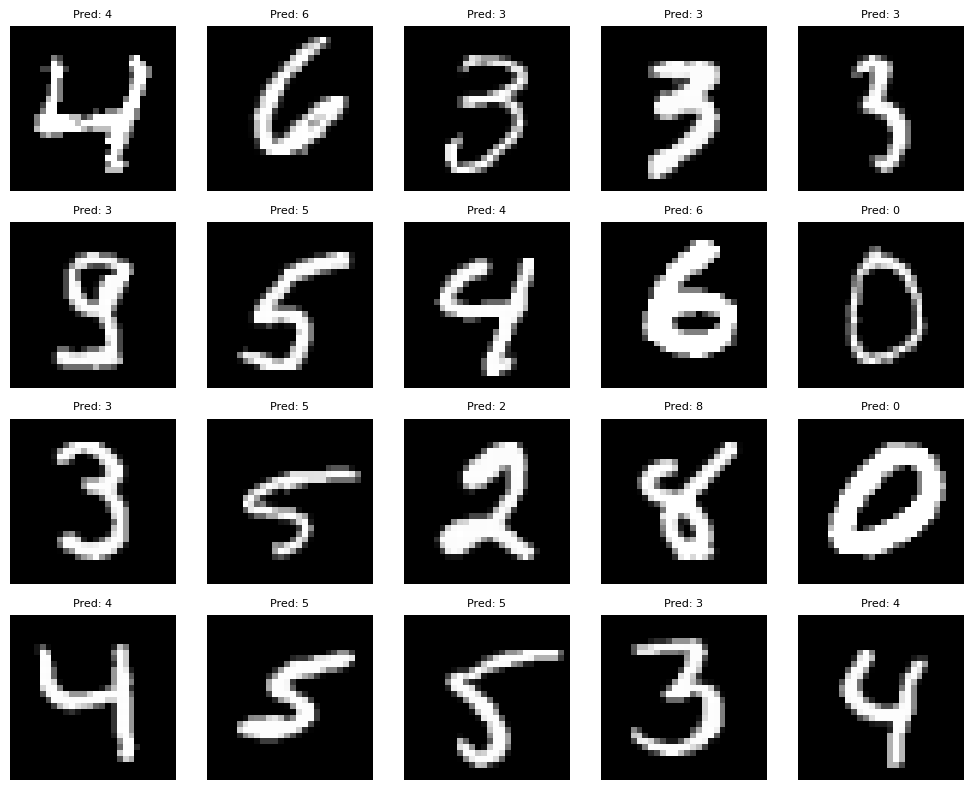

In [14]:
test_it(20)

# Resources

1. https://www.youtube.com/watch?v=vBlO87ZAiiw. NeuralNine. PyTorch Project: Handwritten Digit Recognition.
2. https://github.com/billy-enrizky/Pytorch-Handwritten-Digit-Recognition.
3. https://www.kaggle.com/code/franklemuchahary/mnist-digit-recognition-using-pytorch. not finished.
4. https://github.com/RafayKhattak/Digit-Classification-Pytorch/blob/main/DigitClassificationPytorch.ipynb. not finished.
5. 